In [1]:

%pprint
import sys
if (osp.join('..', 'py') not in sys.path): sys.path.insert(1, osp.join('..', 'py'))

Pretty printing has been turned OFF


In [2]:

from FRVRS import (nu, fu, DataFrame, Index, Series, math, np, osp, re, sm, nan, display, concat)
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df', distance_delta_df='distance_delta_df', scene_stats_df='scene_stats_df')
frvrs_logs_df = data_frames_dict['frvrs_logs_df']
print(frvrs_logs_df.shape) # (829116, 125)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/distance_delta_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/scene_stats_df.pkl.
(829116, 125)


In [4]:

base_mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False)
base_mask_series &= (frvrs_logs_df.is_a_one_triage_file == True)
distance_delta_df = data_frames_dict['distance_delta_df']
print(distance_delta_df.shape) # (873, 15)

(873, 15)


In [5]:

# Add the cluster label where you can
new_column_name = 'cluster_label'
if (new_column_name not in frvrs_logs_df.columns):
    frvrs_logs_df[new_column_name] = nan
    for (session_uuid, scene_id, cluster_label), cluster_label_df in distance_delta_df.groupby(fu.scene_groupby_columns+['cluster_label']):
        
        # Get the whole scene history
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
        scene_df = frvrs_logs_df[mask_series]

        # Mark the scene with the cluster label
        frvrs_logs_df.loc[scene_df.index, new_column_name] = cluster_label

display(frvrs_logs_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}))

,record_count
cluster_label,
0.0,662458
1.0,158698
2.0,4906
3.0,3054


In [6]:

for i in range(4):
    new_column_name = f'is_cluster{i}'
    if (new_column_name not in frvrs_logs_df.columns):
        frvrs_logs_df[new_column_name] = False
        mask_series = (frvrs_logs_df.cluster_label == i)
        frvrs_logs_df.loc[mask_series, new_column_name] = True
    display(i, frvrs_logs_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}))

0

,record_count
is_cluster0,
False,166658
True,662458


1

,record_count
is_cluster1,
False,670418
True,158698


2

,record_count
is_cluster2,
False,824210
True,4906


3

,record_count
is_cluster3,
False,826062
True,3054


In [7]:

# Get the supervised learning and group by columns
target_variable = 'is_cluster2'


def one_hot_encode(df, columns):
    '''
    One-hot encodes the given columns in the given DataFrame.
    
    Args:
        df: A DataFrame.
        columns: A list of column names to encode.
    
    Returns:
        A DataFrame with the encoded columns.
    '''
    
    dummies = pd.get_dummies(df[columns], dummy_na=True)
    df = concat([df, dummies], axis='columns').drop(columns, axis='columns')
    
    return df


# Build a Model to Predict Cluster 2 of the Ideal vs Actual Engagement Distance

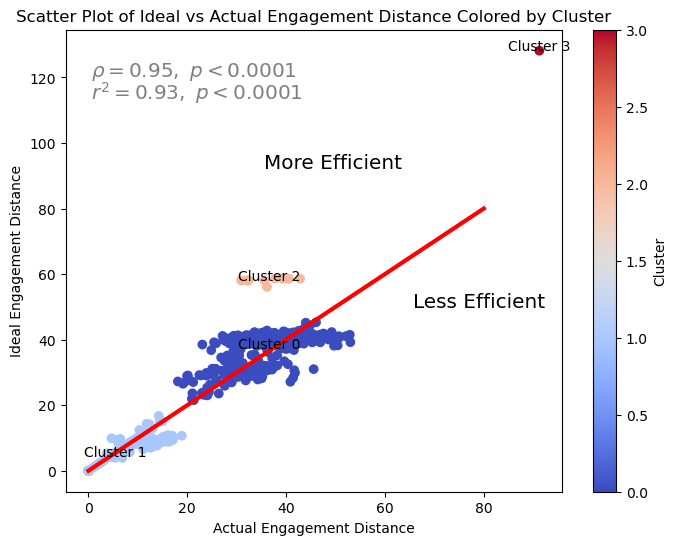

In [8]:

# Create the scatter plot (mappable object)
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.coolwarm
scatter = ax.scatter(distance_delta_df['actual_engagement_distance'], distance_delta_df['ideal_engagement_distance'], c=distance_delta_df['cluster_label'], cmap=cmap)

# Add labels and title
ax.set_xlabel('Actual Engagement Distance')
ax.set_ylabel('Ideal Engagement Distance')
ax.set_title('Scatter Plot of Ideal vs Actual Engagement Distance Colored by Cluster')

# Add the colorbar, referencing the scatter plot
plt.colorbar(scatter, label='Cluster')  # Use the scatter object as the mappable

# Add a dashed diagonal line x=y
ax.plot([0, 80], [0, 80], linestyle='-', color='red', linewidth=3, alpha=1.0)
text_tuple = ax.text(0.4, 0.7, 'More Efficient', alpha=1.0, transform=ax.transAxes, fontsize='x-large')
text_tuple = ax.text(0.7, 0.4, 'Less Efficient', alpha=1.0, transform=ax.transAxes, fontsize='x-large')

# Annotate with Spearman's Rank Correlation Coefficient
s_str = nu.get_spearman_rho_value_latex(distance_delta_df['actual_engagement_distance'], distance_delta_df['ideal_engagement_distance'])
text_tuple = ax.text(0.05, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Annotate with Coefficient of Determination
s_str = nu.get_r_squared_value_latex(distance_delta_df['actual_engagement_distance'], distance_delta_df['ideal_engagement_distance'])
text_tuple = ax.text(0.05, 0.85, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Annotate label centroids with cluster labels
columns_list = ['actual_engagement_distance', 'ideal_engagement_distance']
X = distance_delta_df[columns_list].values
labels = distance_delta_df['cluster_label'].values
for i in range(4):
    ax.annotate(f'Cluster {i}', np.mean(X[labels == i], axis=0), fontsize=10, ha='center')


#### Create a data frame with all the feature columns

In [9]:

scene_stats_df = data_frames_dict['scene_stats_df']

In [10]:

input_features = list(set(scene_stats_df.columns) - set([target_variable, 'session_uuid', 'cluster_label', 'actual_engagement_distance'] + [
    cn for cn in scene_stats_df.columns if any(map(lambda x: x in cn, ['ideal', 'distracted', 'ordering']))
]))

In [12]:

# Add the target variable values back into scene stats
for (session_uuid, scene_id, target_variable_value), _ in frvrs_logs_df.groupby(fu.scene_groupby_columns+[target_variable]):
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (scene_stats_df[cn] == eval(cn))
    scene_stats_df.loc[mask_series, target_variable] = target_variable_value

In [19]:

# Keep track of the target variable and input features columns
columns_list = [target_variable] + input_features
scene_history_df = scene_stats_df[columns_list].dropna(axis='columns', how='all').dropna(axis='index', how='any')

In [20]:

print(scene_history_df.shape) # (873, 41)
print(sorted(scene_history_df.columns))

(616, 41)
['adherence_to_salt', 'combo_complexity', 'combo_entropy', 'combo_turbulence', 'first_engagement', 'first_treatment', 'has_patient_in_agony', 'injury_correctly_treated_count', 'injury_not_treated_count', 'injury_severity_complexity', 'injury_severity_entropy', 'injury_severity_turbulence', 'injury_treated_count', 'injury_wrongly_treated_count', 'is_a_one_triage_file', 'is_cluster2', 'is_scene_aborted', 'last_engagement', 'last_still_engagement', 'logger_version', 'patient_count', 'patient_sort_complexity', 'patient_sort_entropy', 'patient_sort_turbulence', 'percent_hemorrhage_controlled', 'pulse_taken_count', 'scene_end', 'scene_id', 'scene_start', 'scene_type', 'stills_value', 'teleport_count', 'time_to_last_hemorrhage_controlled', 'total_actions', 'triage_time', 'voice_capture_count', 'walk_command_count', 'walk_value', 'walkers_value', 'wave_command_count', 'wave_value']


In [21]:

df = scene_history_df.sample(min(14, scene_history_df.shape[0])).dropna(axis='columns', how='all').T
display(df.sample(min(20, df.shape[0])).sort_index())

,371,85,588,447,849,116,647,156,518,190,604,105,187,272
adherence_to_salt,False,True,True,False,False,False,False,False,False,False,True,False,True,False
combo_complexity,0.635739,0.849322,0.519079,0.76844,0.849322,0.583976,0.635739,0.519079,0.734088,0.624545,0.519079,0.635739,0.849322,0.698263
first_treatment,196097.0,108240.0,88368.0,121241.0,178781.0,605655.0,388372.0,297526.0,316247.0,138405.0,425117.0,181903.0,59854.0,49908.0
has_patient_in_agony,True,False,True,True,False,True,True,True,True,True,True,True,False,True
injury_severity_complexity,0.736133,0.757824,0.60105,0.76844,0.757824,0.662932,0.736133,0.60105,0.850013,0.718655,0.60105,0.736133,0.757824,0.67224
injury_severity_entropy,0.992215,0.946395,0.992215,0.864974,0.946395,0.965634,0.992215,0.992215,0.992215,0.894965,0.992215,0.992215,0.946395,0.894965
injury_severity_turbulence,9.840447,3.584963,10.733913,4.321928,3.584963,8.119884,9.463593,10.293259,9.451956,9.502583,10.129283,9.463593,3.584963,9.457746
injury_treated_count,13,4,9,3,5,7,9,16,8,7,9,5,4,13
injury_wrongly_treated_count,5,0,1,0,2,1,1,7,0,0,2,0,0,0
is_scene_aborted,False,False,False,False,False,False,False,False,False,False,False,False,False,False



#### One-hot encode it

In [22]:

# One-hot encode the input features columns in the one-hot encode data frame
ascii_regex = re.compile('[^a-z0-9]+')
one_hot_encode_df = one_hot_encode(scene_history_df, ['scene_type'])
one_hot_encode_df = one_hot_encode_df.rename(columns={cn: ascii_regex.sub('_', cn.lower()).strip('_') for cn in one_hot_encode_df.columns})
columns_list = [cn for cn in one_hot_encode_df.columns if any(map(lambda x: cn.endswith(x), ['_null', '_nan']))]
print(columns_list)
df = one_hot_encode_df.sample(min(12, one_hot_encode_df.shape[0])).dropna(axis='columns', how='all').T
display(df.sample(min(20, df.shape[0])).sort_index())

['scene_type_nan']


,415,553,685,643,245,746,216,516,103,800,715,783
adherence_to_salt,False,False,True,True,True,False,True,False,False,False,False,True
combo_entropy,1.0,0.933817,1.0,1.0,1.0,0.933817,1.0,1.0,0.933817,0.876358,1.0,1.0
combo_turbulence,4.0,9.540352,4.0,4.0,4.0,9.386085,4.0,3.0,9.386085,7.956177,3.0,4.0
first_engagement,28823.0,247992.0,46684.0,52494.0,184982.0,277070.0,52619.0,138508.0,69322.0,446757.0,42063.0,51647.0
injury_severity_entropy,0.946395,0.992215,0.946395,0.946395,0.946395,0.992215,0.946395,0.918296,0.992215,0.878347,1.0,0.946395
injury_treated_count,4,9,4,4,4,8,4,2,7,8,2,4
injury_wrongly_treated_count,0,1,0,0,0,1,0,0,0,3,0,0
is_cluster2,False,False,False,False,False,False,False,False,False,False,False,False
patient_count,4,11,4,4,5,11,4,4,11,11,4,4
patient_sort_complexity,0.928141,0.786692,0.757824,0.757824,0.757824,0.664876,0.757824,0.954065,0.664876,0.622995,0.813886,0.757824


In [23]:

# Demonstrate that you have no nulls in the data frame
one_hot_encode_df.shape, one_hot_encode_df.dropna(axis='index', how='any').shape

((616, 43), (616, 43))

In [24]:

# Analyze the input features
one_hot_column_descriptions_df = nu.get_column_descriptions(one_hot_encode_df.sample(min(2000, one_hot_encode_df.shape[0])))
    
display(one_hot_column_descriptions_df.sample(min(20, one_hot_column_descriptions_df.shape[0])).sort_index())

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
2,is_a_one_triage_file,bool,0,2,99,False,False,True,True
3,has_patient_in_agony,bool,0,2,216,False,False,True,True
8,percent_hemorrhage_controlled,float64,0,35,4,True,0.0,200.0,False
9,patient_sort_complexity,float64,0,57,0,True,0.420505,1.201122,False
12,combo_turbulence,float64,0,234,0,True,2.0,15.787986,False
15,first_treatment,float64,0,615,0,True,27550.0,7252125.0,True
18,injury_severity_entropy,float64,0,31,0,True,0.721928,1.0,False
19,stills_value,int64,0,2,387,True,0,1,True
21,pulse_taken_count,int64,0,62,6,True,0,94,True
23,walkers_value,int64,0,2,335,True,0,1,True



#### Train a classifier on it

In [32]:

# Train a classifier on the patient history data frame
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
df = one_hot_encode_df.dropna(axis='index', how='any')
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target_variable], axis='columns'),
    df[target_variable],
    test_size=0.25,
    random_state=42
)

# Convert the uint8 features to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Convert the boolean labels to integers (True to 1, False to 0)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [33]:

# Create a random forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = rf_classifier.predict(X_test)
rf_accuracy = np.mean(y_pred == y_test)

# Calculate the feature importances
feature_importances = rf_classifier.feature_importances_

# Create a data frame to store the feature names and feature importances
feature_importances_df = DataFrame()
feature_importances_df['feature_name'] = df.drop(target_variable, axis='columns').columns
feature_importances_df['feature_importance'] = feature_importances

In [34]:

# Train a logistic regression classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = lr_classifier.predict(X_test)
lr_accuracy = np.mean(y_pred == y_test)

# Get the coefficients of the logistic regression model
feature_coefficients = lr_classifier.coef_[0]

# Create a data frame to store the feature names and feature coefficients
feature_coefficients_df = DataFrame()
feature_coefficients_df['feature_name'] = df.drop(target_variable, axis='columns').columns
feature_coefficients_df['feature_coefficient'] = feature_coefficients
feature_coefficients_df['absolute_coefficient'] = feature_coefficients_df.feature_coefficient.map(lambda x: abs(x))

In [35]:

from sklearn.inspection import permutation_importance

# Train a histogram-based gradient boosting classifier
hgb_classifier = HistGradientBoostingClassifier().fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = hgb_classifier.predict(X_test)
hgb_accuracy = np.mean(y_pred == y_test)

# Calculate the feature importances using the Permutation Importance algorithm
hgb_permutation_importances = permutation_importance(hgb_classifier, X_test, y_test)

In [36]:

# Create a data frame to store the feature names and feature coefficients
hgb_permutation_importances_df = DataFrame()
hgb_permutation_importances_df['feature_name'] = df.drop(target_variable, axis='columns').columns
for fn in dir(hgb_permutation_importances):
    
    # Iterate through each column
    if (fn == 'importances'):
        for i, importances in enumerate(
            [hgb_permutation_importances.importances[:, i] for i in range(hgb_permutation_importances.importances.shape[1])]
        ):
            hgb_permutation_importances_df[f'importance{i}'] = importances
    
    else: hgb_permutation_importances_df[fn] = eval(f'hgb_permutation_importances.{fn}')


#### Evaluate the accuracies and importances

In [37]:

# Print the accuracies
print('RF Accuracy:', rf_accuracy)
print('LR Accuracy:', lr_accuracy)
print('HGB Accuracy:', hgb_accuracy)

RF Accuracy: 0.974025974025974
LR Accuracy: 0.961038961038961
HGB Accuracy: 0.987012987012987


In [38]:

# Display the feature importances data frame
display(feature_importances_df.sort_values('feature_importance', ascending=False).head(10))

,feature_name,feature_importance
35,combo_entropy,0.133728
37,walk_value,0.094231
10,injury_treated_count,0.085316
8,voice_capture_count,0.080791
15,walk_command_count,0.062070
16,injury_severity_complexity,0.057016
18,injury_correctly_treated_count,0.053874
11,time_to_last_hemorrhage_controlled,0.043135
34,scene_start,0.039090
4,patient_sort_entropy,0.026387


In [39]:

# Display the feature coefficients data frame
columns_list = ['feature_name', 'feature_coefficient']
display(feature_coefficients_df.sort_values('absolute_coefficient', ascending=False)[columns_list].head(10))

,feature_name,feature_coefficient
3,total_actions,-0.000406
12,percent_hemorrhage_controlled,0.000056
11,time_to_last_hemorrhage_controlled,-0.000033
33,first_engagement,0.000028
6,pulse_taken_count,0.000027
19,last_still_engagement,0.000023
22,teleport_count,0.000018
29,last_engagement,-0.000017
31,first_treatment,-0.000015
8,voice_capture_count,-0.000008


In [40]:

# Display the permutation importances data frame
columns_list = ['feature_name', 'importances_mean']
df = hgb_permutation_importances_df.drop(columns_list, axis='columns')
max_importance = df.max().max()
columns_list += df.columns[df.eq(max_importance).any()].tolist()[:7-len(columns_list)]
display(hgb_permutation_importances_df.sort_values('importances_mean', ascending=False)[columns_list].head(10))

,feature_name,importances_mean,importance1
19,last_still_engagement,0.014286,0.019481
35,combo_entropy,0.012987,0.012987
3,total_actions,0.007792,0.012987
15,walk_command_count,0.006494,0.006494
38,injury_severity_entropy,0.006494,0.006494
10,injury_treated_count,0.005195,0.006494
12,percent_hemorrhage_controlled,0.003896,0.006494
24,wave_command_count,0.002597,0.000000
17,injury_not_treated_count,0.002597,0.006494
22,teleport_count,0.002597,0.000000


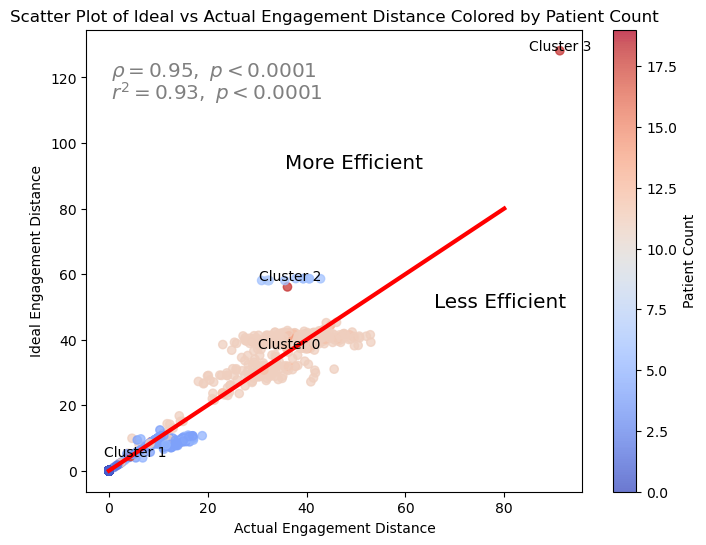

In [41]:

# Create the scatter plot (mappable object)
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.coolwarm
scatter = ax.scatter(scene_stats_df['actual_engagement_distance'], scene_stats_df['ideal_engagement_distance'], c=scene_stats_df['patient_count'], cmap=cmap, alpha=0.75)

# Add labels and title
ax.set_xlabel('Actual Engagement Distance')
ax.set_ylabel('Ideal Engagement Distance')
ax.set_title('Scatter Plot of Ideal vs Actual Engagement Distance Colored by Patient Count')

# Add the colorbar, referencing the scatter plot
plt.colorbar(scatter, label='Patient Count')  # Use the scatter object as the mappable

# Add a dashed diagonal line x=y
ax.plot([0, 80], [0, 80], linestyle='-', color='red', linewidth=3, alpha=1.0)
text_tuple = ax.text(0.4, 0.7, 'More Efficient', alpha=1.0, transform=ax.transAxes, fontsize='x-large')
text_tuple = ax.text(0.7, 0.4, 'Less Efficient', alpha=1.0, transform=ax.transAxes, fontsize='x-large')

# Annotate with Spearman's Rank Correlation Coefficient
s_str = nu.get_spearman_rho_value_latex(scene_stats_df['actual_engagement_distance'], scene_stats_df['ideal_engagement_distance'])
text_tuple = ax.text(0.05, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Annotate with Coefficient of Determination
s_str = nu.get_r_squared_value_latex(scene_stats_df['actual_engagement_distance'], scene_stats_df['ideal_engagement_distance'])
text_tuple = ax.text(0.05, 0.85, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Annotate label centroids with cluster labels
columns_list = ['actual_engagement_distance', 'ideal_engagement_distance']
X = scene_stats_df[columns_list].values
labels = scene_stats_df['cluster_label'].values
for i in range(4): ax.annotate(f'Cluster {i}', np.mean(X[labels == i], axis=0), fontsize=10, ha='center')

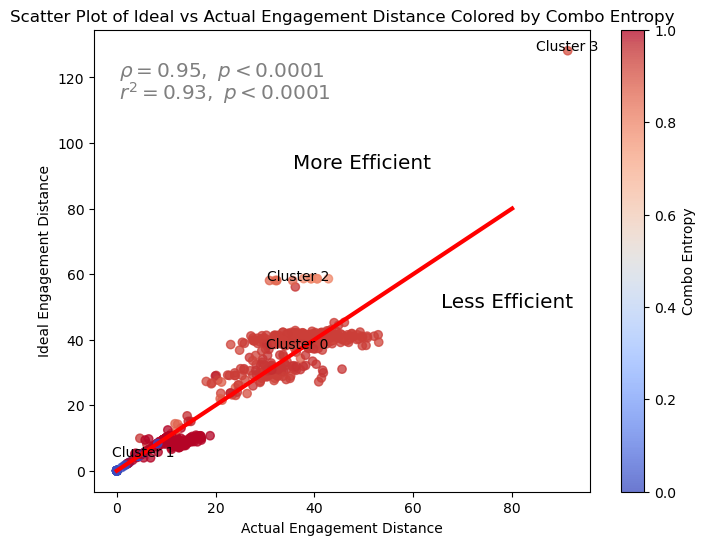

In [42]:

# Create the scatter plot (mappable object)
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.coolwarm
scatter = ax.scatter(scene_stats_df['actual_engagement_distance'], scene_stats_df['ideal_engagement_distance'], c=scene_stats_df['combo_entropy'], cmap=cmap, alpha=0.75)

# Add labels and title
ax.set_xlabel('Actual Engagement Distance')
ax.set_ylabel('Ideal Engagement Distance')
ax.set_title('Scatter Plot of Ideal vs Actual Engagement Distance Colored by Combo Entropy')

# Add the colorbar, referencing the scatter plot
plt.colorbar(scatter, label='Combo Entropy')  # Use the scatter object as the mappable

# Add a dashed diagonal line x=y
ax.plot([0, 80], [0, 80], linestyle='-', color='red', linewidth=3, alpha=1.0)
text_tuple = ax.text(0.4, 0.7, 'More Efficient', alpha=1.0, transform=ax.transAxes, fontsize='x-large')
text_tuple = ax.text(0.7, 0.4, 'Less Efficient', alpha=1.0, transform=ax.transAxes, fontsize='x-large')

# Annotate with Spearman's Rank Correlation Coefficient
s_str = nu.get_spearman_rho_value_latex(scene_stats_df['actual_engagement_distance'], scene_stats_df['ideal_engagement_distance'])
text_tuple = ax.text(0.05, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Annotate with Coefficient of Determination
s_str = nu.get_r_squared_value_latex(scene_stats_df['actual_engagement_distance'], scene_stats_df['ideal_engagement_distance'])
text_tuple = ax.text(0.05, 0.85, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Annotate label centroids with cluster labels
columns_list = ['actual_engagement_distance', 'ideal_engagement_distance']
X = scene_stats_df[columns_list].values
labels = scene_stats_df['cluster_label'].values
for i in range(4): ax.annotate(f'Cluster {i}', np.mean(X[labels == i], axis=0), fontsize=10, ha='center')


#### Perform a sample inference

In [43]:

# Display the one-hot encoded sample
input_encode_df = one_hot_encode_df.sample(1)
input_encode_idx = input_encode_df.index.item()
print(input_encode_idx)
print(input_encode_df.shape)
mask_series = (input_encode_df.T[input_encode_idx] == 0)
df = input_encode_df.T[~mask_series]
enc_idx_list = df.index.tolist()
display(df)

110
(1, 43)


,110
logger_version,1.3
adherence_to_salt,True
stills_value,1
total_actions,760
patient_sort_entropy,0.971307
injury_severity_turbulence,12.400968
pulse_taken_count,21
patient_sort_turbulence,11.53472
voice_capture_count,72
walkers_value,1


In [58]:

# Display the FRVRS Logs sample
mask_series = (scene_stats_df.index == input_encode_idx)
df = scene_stats_df[mask_series]
mask_series = (frvrs_logs_df.session_uuid == df.session_uuid.squeeze()) & (frvrs_logs_df.scene_id == df.scene_id.squeeze())
df = frvrs_logs_df[mask_series]
print(df.shape)
cn_set = set()
for cn in frvrs_logs_df.columns:
    for enc_idx in enc_idx_list:
        if enc_idx.startswith(cn): cn_set.add(cn)
columns_list = [target_variable] + list(cn_set)
display(df[columns_list].drop_duplicates().sort_values(columns_list).T)

(895, 130)


,16135,16138,16170,16147,16151,16167,16134
is_cluster2,False,False,False,False,False,False,False
logger_version,1.3,1.3,1.3,1.3,1.3,1.3,1.3
patient_sort,still,waver,walker,NaN,NaN,NaN,NaN
scene_type,Triage,Triage,Triage,Triage,Triage,Triage,Triage
scene_id,1,1,1,1,1,1,1
is_a_one_triage_file,True,True,True,True,True,True,True
injury_severity,NaN,NaN,NaN,high,medium,low,NaN


In [45]:

# Display the scene history sample
mask_series = (scene_history_df.index == input_encode_idx)
df = scene_history_df[mask_series]
print(df.shape)
cn_set = set()
for cn in scene_history_df.columns:
    for enc_idx in enc_idx_list:
        if enc_idx.startswith(cn): cn_set.add(cn)
columns_list = [target_variable] + list(cn_set - set([target_variable]))
display(df[columns_list].T)

(1, 41)


,110
is_cluster2,False
logger_version,1.3
adherence_to_salt,True
stills_value,1
total_actions,760
patient_sort_entropy,0.971307
injury_severity_turbulence,12.400968
pulse_taken_count,21
patient_sort_turbulence,11.53472
voice_capture_count,72


In [46]:

# Convert the input features to a NumPy array
input_features_array = np.array(input_encode_df.drop(target_variable, axis='columns').values)
actual_target_value = input_encode_df[target_variable].squeeze()

In [49]:

# Predict the target value
predicted_target_value = sorted(
    [(c, p) for c, p in zip(lr_classifier.classes_, lr_classifier.predict_proba(input_features_array)[0])], key=lambda x: x[1], reverse=True
)[0][0]
print(f'LR: predicted: {[False, True][predicted_target_value]}, actual: {actual_target_value}')

LR: predicted: False, actual: False


In [50]:

# Predict the target value
predicted_target_value = sorted(
    [(c, p) for c, p in zip(rf_classifier.classes_, rf_classifier.predict_proba(input_features_array)[0])], key=lambda x: x[1], reverse=True
)[0][0]
print(f'RF: predicted: {[False, True][predicted_target_value]}, actual: {actual_target_value}')

RF: predicted: False, actual: False


In [51]:

# Predict the target value
predicted_target_value = sorted(
    [(c, p) for c, p in zip(hgb_classifier.classes_, hgb_classifier.predict_proba(input_features_array)[0])], key=lambda x: x[1], reverse=True
)[0][0]
print(f'HGB: predicted: {[False, True][predicted_target_value]}, actual: {actual_target_value}')

HGB: predicted: False, actual: False
